In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [208]:
from datetime import datetime, timedelta

def generate_date_array(start_date, length):
    date_array = []
    current_date = start_date

    while len(date_array) < length:
        if current_date.weekday() < 5:  # Check if it's a weekday
            date_array.append(current_date)
        current_date += timedelta(days=1)  # Move to the next day

    return date_array

In [209]:
_split = 0.9
epochs = 200
batch_size = 64
time_step = 30

## VCB

In [210]:
# Load the stock data
data_path = '../../Dataset/VCB.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

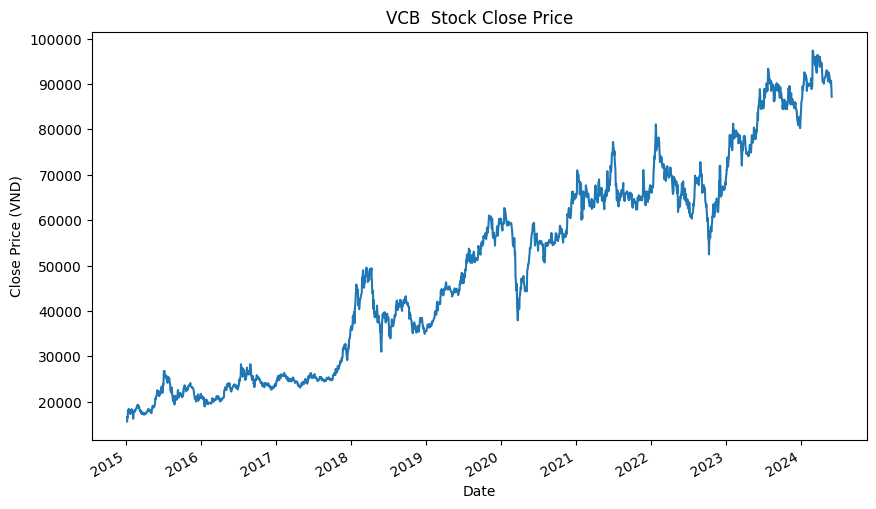

In [211]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [212]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

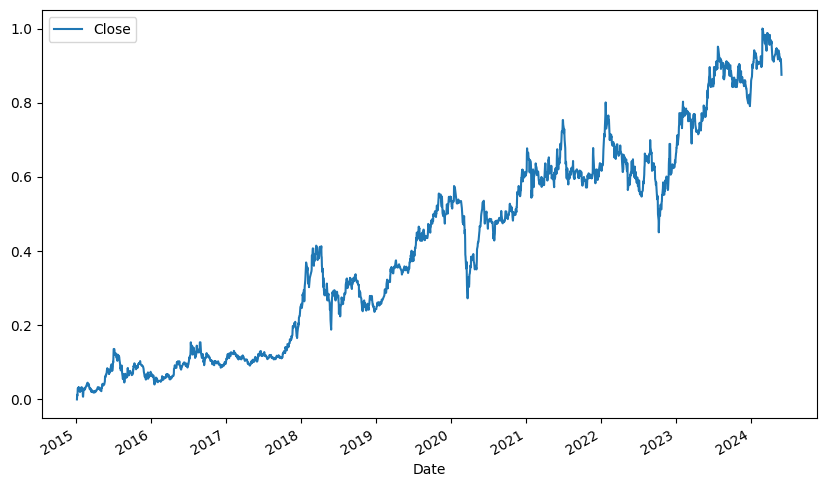

In [213]:
dataset.plot(figsize=(10, 6))

In [214]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2105, 234)

In [215]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [216]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [217]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [218]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [219]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2105, 30), (2105,), (234, 30), (234,))

In [220]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [221]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2105, 30, 1), y_train Shape: (2105,)
X_test Shape: (234, 30, 1), y_test Shape: (234,)


In [222]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [223]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0736 - val_loss: 0.0014
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - val_loss: 7.6962e-04
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6712e-04 - val_loss: 5.2653e-04
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9392e-04 - val_loss: 3.8662e-04
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7474e-04 - val_loss: 4.6029e-04
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0850e-04 - val_loss: 7.6119e-04
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0987e-04 - val_loss: 3.3560e-04
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8321e-04 - val_loss: 3.0399e-04
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.7049e-04 - val_loss: 2.8390e-04
Epoch 10/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1765e-04 - val_loss: 3.5929e-04
Epoch 11/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9311e-04 - val_los

In [224]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [225]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [226]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 926.115, Train MAE: 661.774, Train MAPE: 1.551%
Test RMSE: 1130.351, Test MAE: 800.082, Test MAPE: 0.902%


In [227]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [228]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

In [229]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

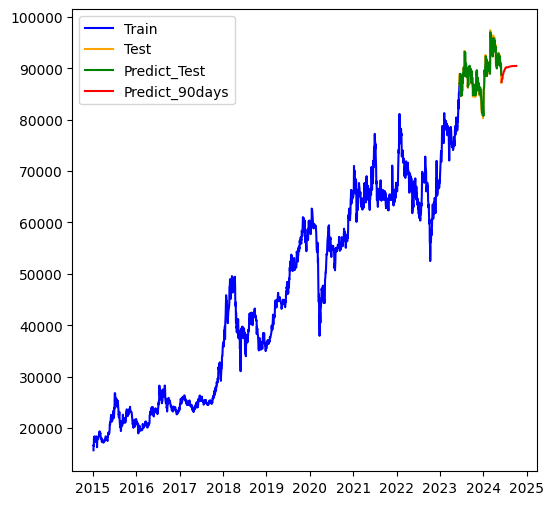

In [230]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.legend()
plt.show()

## BID

In [231]:
# Load the stock data
data_path = '../../Dataset/BID.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

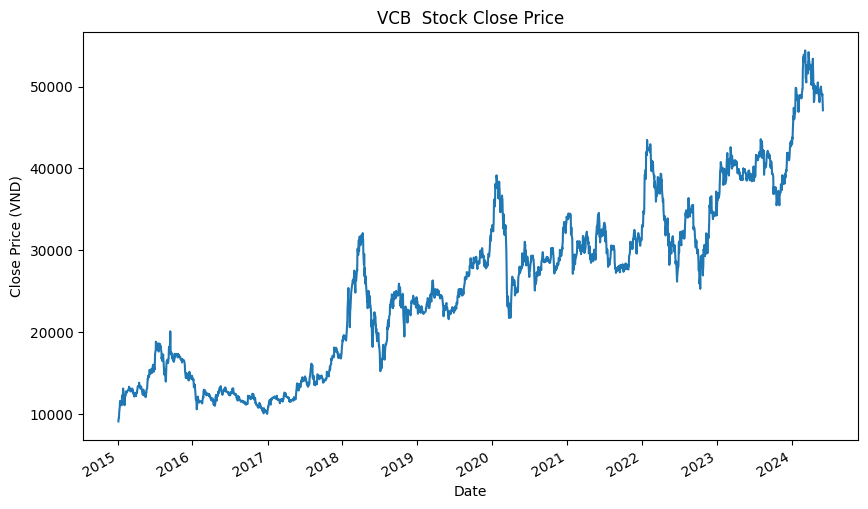

In [232]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [233]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

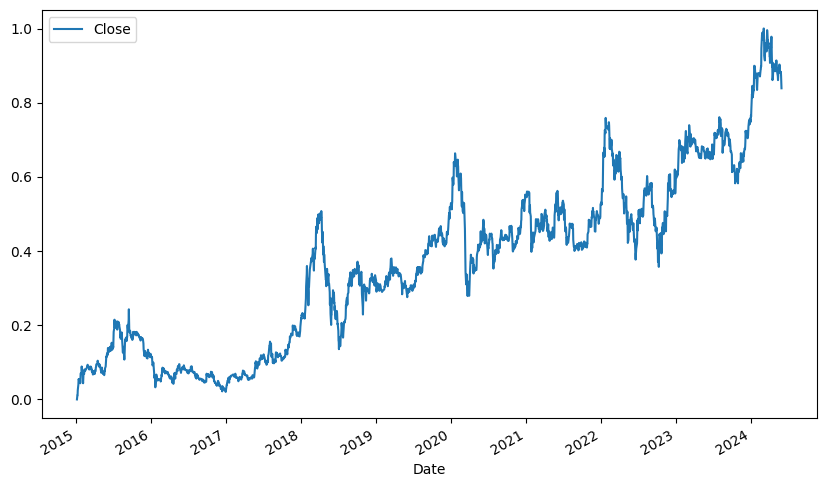

In [234]:
dataset.plot(figsize=(10, 6))

In [235]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2110, 235)

In [236]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [237]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [238]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [239]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [240]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2110, 30), (2110,), (235, 30), (235,))

In [241]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [242]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2110, 30, 1), y_train Shape: (2110,)
X_test Shape: (235, 30, 1), y_test Shape: (235,)


In [243]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [244]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2420 - val_loss: 0.0024
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.9993e-04 - val_loss: 0.0012
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4198e-04 - val_loss: 0.0011
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3867e-04 - val_loss: 0.0012
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.1368e-04 - val_loss: 0.0015
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0582e-04 - val_loss: 0.0010
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9471e-04 - val_loss: 9.3792e-04
Epoch 10/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5027e-04 - val_loss: 0.0010
Epoch 11/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5699e-04 - val_loss: 0.0011
Epoch 12/200
33/33 ━━━━━━━

In [245]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [246]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [247]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 630.236, Train MAE: 454.962, Train MAPE: 2.061%
Test RMSE: 1180.279, Test MAE: 942.89, Test MAPE: 2.071%


In [248]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [249]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [250]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

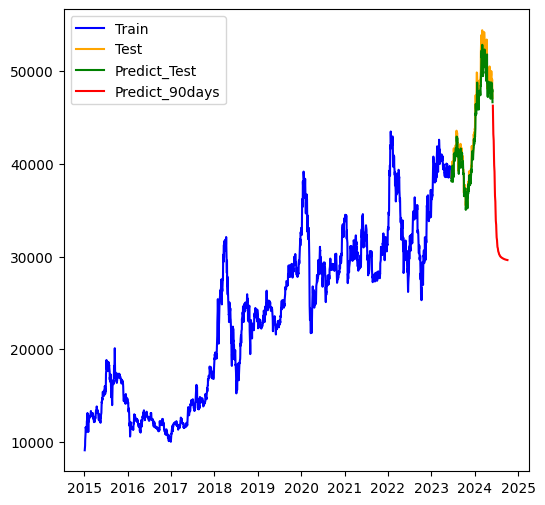

In [251]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.legend()
plt.show()

## CTG

In [252]:
# Load the stock data
data_path = '../../Dataset/CTG.csv'
data = pd.read_csv(data_path) 
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close']]

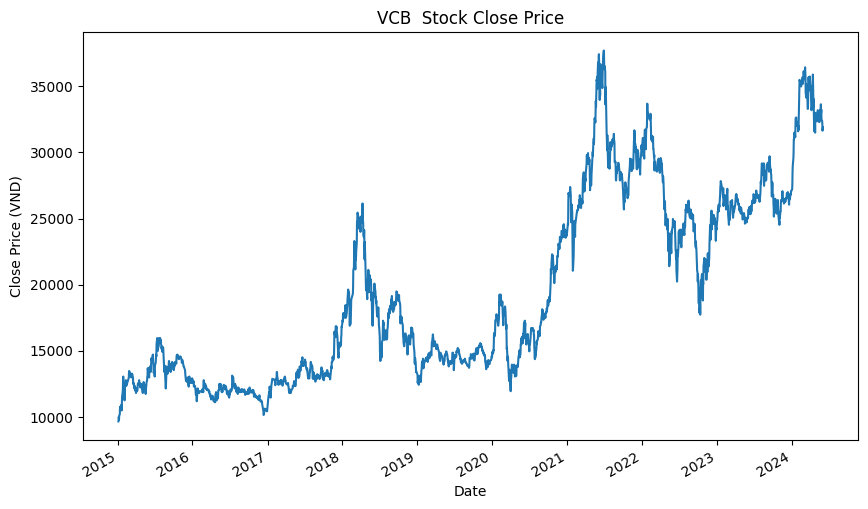

In [253]:
# Plot the data
plt.figure(figsize=(10, 6))
data['Close'].plot()
plt.title("VCB  Stock Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price (VND)')
plt.show()

In [254]:
# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
dataset = pd.DataFrame(data_scaled, columns=['Close'])
dataset.set_index(data.index, inplace=True)

<Axes: xlabel='Date'>

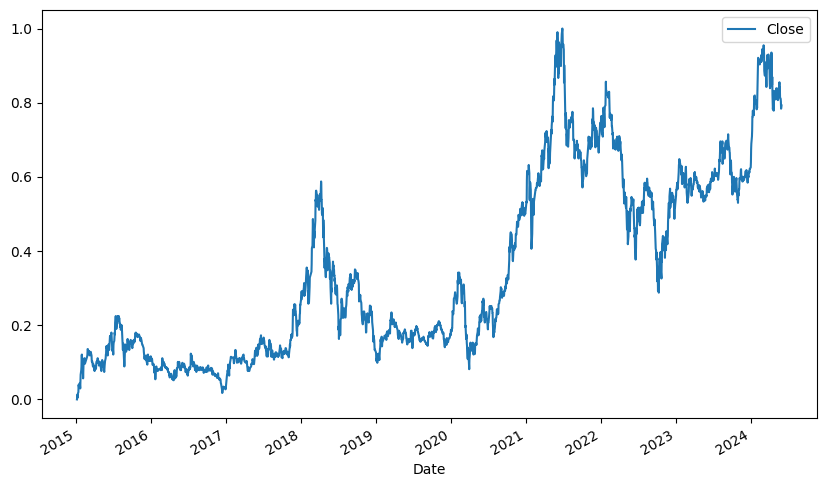

In [255]:
dataset.plot(figsize=(10, 6))

In [256]:
train_size = int(len(dataset) * _split)
test_size = len(dataset) - train_size

train_data = data[:train_size]
test_data = data[train_size:]

train_size, test_size

(2110, 235)

In [257]:
train_data_scaled = dataset[:train_size]
test_data_scaled = dataset[train_size:]

In [258]:
def create_data_for_RNN(data, time_step=60):
    X, y = [], []
    for i in range(0, len(data)):
        if(i-time_step >= 0):
            X.append(data[i-time_step:i])
            y.append(data[i])
        else:
            X.append(np.zeros(time_step))
            y.append(data[i])
    return np.array(X), np.array(y)

In [259]:
X, y = create_data_for_RNN(dataset['Close'].values, time_step=time_step)

In [260]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [261]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2110, 30), (2110,), (235, 30), (235,))

In [262]:
# Reshape the data for RNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [263]:
print(f"X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")

X_train Shape: (2110, 30, 1), y_train Shape: (2110,)
X_test Shape: (235, 30, 1), y_test Shape: (235,)


In [264]:
# Build the RNN model
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\vanma\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [265]:
# Train the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0445 - val_loss: 0.0141
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6062e-04 - val_loss: 0.0010
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2656e-04 - val_loss: 8.6625e-04
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0385e-04 - val_loss: 7.6190e-04
Epoch 6/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3456e-04 - val_loss: 6.8457e-04
Epoch 7/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3072e-04 - val_loss: 0.0013
Epoch 8/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8685e-04 - val_loss: 6.0017e-04
Epoch 9/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.9010e-04 - val_loss: 6.5087e-04
Epoch 10/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7301e-04 - val_loss: 6.6163e-04
Epoch 11/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5237e-04 - val_loss: 7.7542e-0

In [266]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [267]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [268]:
# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
train_mae = mean_absolute_error(y_train, train_predict)
train_mape = np.mean(np.abs((y_train - train_predict) / y_train)) * 100

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
test_mae = mean_absolute_error(y_test, test_predict)
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100

# Round the metrics to three decimal places
train_rmse = round(train_rmse, 3)
train_mae = round(train_mae, 3)
train_mape = round(train_mape, 3)

test_rmse = round(test_rmse, 3)
test_mae = round(test_mae, 3)
test_mape = round(test_mape, 3)

print(f"Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train MAPE: {train_mape}%")
print(f"Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test MAPE: {test_mape}%")

Train RMSE: 499.328, Train MAE: 363.043, Train MAPE: 2.042%
Test RMSE: 564.739, Test MAE: 412.831, Test MAPE: 1.382%


In [269]:
def predict_future_prices(days):
    future_prices = []
    X = []
    for i in range(0, time_step):        
        X = test_data_scaled['Close'].values[i-time_step:]
        if(i > 0):
            X = np.append(X, future_prices[:i])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    for i in range(0, days-time_step):
        X = np.array(future_prices[i:i+time_step])
        pred = model.predict(X.reshape(1, time_step, 1))
        future_prices.append(pred[0][0])
        X = []
    return np.array(future_prices)


In [270]:
future_days = 90
future_dates = generate_date_array(data.index[-1] + timedelta(days=1), future_days)
future_prices = predict_future_prices(future_days)
future_prices = scaler.inverse_transform(future_prices.reshape(-1, 1))
future_data = pd.DataFrame(future_prices, columns=['Close'], index=future_dates)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [271]:
test_predict = test_predict.reshape(-1)
test_predict = pd.DataFrame(test_predict, columns=['Close'], index=test_data.index)

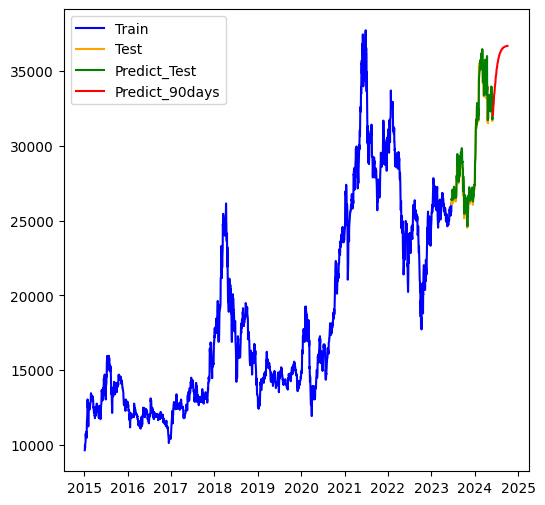

In [272]:
plt.figure(figsize=(6, 6))
plt.plot(train_data.index, train_data['Close'], label='Train', color='blue')
plt.plot(test_data.index, test_data['Close'], label='Test', color='orange')
plt.plot(test_predict.index, test_predict['Close'], label='Predict_Test', color='green')
plt.plot(future_data.index, future_data['Close'], label='Predict_90days', color='red')
plt.legend()
plt.show()